# **Top 10 complaint phases（ KeyBERT + all-mpnet-base-v2 + NRC-Guided Adj-Noun Filtering）**



In [ ]:
#@title connect google drive folder

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMU_MITB_NLP/Groupproject/

Mounted at /content/drive
/content/drive/MyDrive/SMU_MITB_NLP/Groupproject


In [ ]:
!pip install -U transformers

In [ ]:
import pandas as pd

# 1. 读取数据
file_path = '/content/drive/MyDrive/SMU_MITB_NLP/Groupproject/USS_Reviews_Silver_cleaned_l2.csv'
df = pd.read_csv(file_path)

# 2. 只取1-2星评论
df_low = df[df['stars'].isin([1, 4])]
texts = df_low['integrated_review'].astype(str).tolist()

# 3. 描述性统计
print("—— 1-2星评论基本信息 ——")
print(f"总评论数: {len(df)}")
print(f"1-2星评论数: {len(df_low)}")
print(f"1-2星评论占比: {len(df_low)/len(df):.2%}")
print()



print("—— 1-2星评论示例 ——")
for i, row in df_low[['stars', 'integrated_review']].head(5).iterrows():
    print(f"{int(row['stars'])}星：{row['integrated_review']}\n")



—— 1-2星评论基本信息 ——
总评论数: 24021
1-2星评论数: 6162
1-2星评论占比: 25.65%

—— 1-2星评论示例 ——
4星：Nice lot if activities need entire day to cover all [VISIT_TIME: Weekday] [WAIT_TIME: No wait]

4星：We went there to enjoy the Minions. It's hot during the day, so you'll need to take precautions against the heat. I was glad that the rides were empty as the museum approached closing time [VISIT_TIME: Weekday]

1星：Are there people who come to reserve a queue for other people? Reserve a queue for a family of 5-6 Indians in front of them. They said that this is Singapore.

4星：Thanks to the hot weather, there are hardly any lines.

4星：Fun experience! Can spend 2/3 - 1 day here! Quite small compared to other countries, but still enough rides and entertainment for a day.



# **✅Final Complaint Phrase Extraction Pipeline: KeyBERT + all-mpnet-base-v2 + NRC-Guided Adj-Noun Filtering**

🔍 **Extracting High-Quality Complaint Phrases Using KeyBERT + all-mpnet-base-v2 + NRC Lexicon**

This pipeline is designed to extract high-quality complaint phrases from user reviews by combining semantic embeddings, emotion lexicons, and clustering analysis.

---

### ✅ Why all-mpnet-base-v2?

We chose the `all-mpnet-base-v2` model for its **robustness on subjective and short-form texts**, which are common in user reviews. Compared to `E5-large` and `GTE-large`, it:
- Performs better on **emotionally charged**, lifestyle-related expressions,
- Is **computationally efficient** for Colab usage with 768-dimensional embeddings.

---

### 🧠 Emotion-Aware Filtering: NRC Lexicon

We incorporate the **NRC Emotion Lexicon**, which assigns each word a binary label (`0` or `1`) across 10 categories:

| Emotion Category       |
|------------------------|
| positive               |
| negative               |
| anger                  |
| anticipation           |
| disgust                |
| fear                   |
| joy                    |
| sadness                |
| surprise               |
| trust                  |

In this project, we **focus specifically on negative adjectives** as the emotional filter.  
Only phrases matching the `ADJ + NOUN` pattern, where the adjective exists in the NRC negative list, are retained — ensuring emotional relevance.

---

### 💬 Phrase Sourcing

Candidate phrases are drawn from two sources:

- **KeyBERT (using `all-mpnet-base-v2`)** to extract top 2–3 word phrases.
- **SpaCy `noun_chunks`** to capture additional noun phrases.

Location and brand-related terms (e.g., *Sentosa*, *USS*, *Singapore*) are filtered out using `spaCy` NER.

---

### 📊 Clustering with KMeans

- All candidate phrases are embedded and clustered using **KMeans** (e.g., `n_clusters = 15`).
- Each cluster is scanned for valid complaint phrases.
- The **phrase closest to the centroid** is selected as the **representative phrase**, with all matching cluster members displayed.

This combination of **semantic filtering**, **emotion constraints**, and **representative clustering** provides a scalable and interpretable way to extract actionable user complaints.

In [ ]:
import pandas as pd
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from keybert import KeyBERT

# 1. 评论文本
texts = df_low['integrated_review'].dropna().astype(str).tolist()
nlp = spacy.load('en_core_web_sm')#

def is_brand_or_location(phrase):
    doc = nlp(phrase)
    for ent in doc.ents:
        if ent.label_ in ['ORG', 'GPE', 'LOC', 'PRODUCT', 'FAC']:
            return True
    bad_keywords = ['uss', 'universal', 'studios', 'sentosa', 'disney', 'singapore']
    return any(bad in phrase.lower() for bad in bad_keywords)

# 2. NRC负面形容词
nrc_path = '/content/drive/MyDrive/SMU_MITB_NLP/Groupproject/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
negative_adjs = set()
with open(nrc_path, encoding='utf-8') as f:
    for line in f:
        word, emotion, flag = line.strip().split('\t')
        if int(flag) == 1 and emotion == 'negative':
            negative_adjs.add(word)

# 3. KeyBERT抽取短语 + 所有noun短语
kw_model = KeyBERT('all-mpnet-base-v2')
all_keybert_phrases = []
for text in texts:
    phrases = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(2, 3),
        stop_words='english',
        top_n=3
    )
    all_keybert_phrases.extend([kw[0] for kw in phrases])
all_keybert_phrases = [p for p in set(all_keybert_phrases) if not is_brand_or_location(p)]

# noun_chunks
all_noun_phrases = []
for text in texts:
    doc = nlp(text)
    all_noun_phrases += [chunk.text.lower().strip() for chunk in doc.noun_chunks if not is_brand_or_location(chunk.text)]
all_noun_phrases = list(set(all_noun_phrases))

# 合并聚类池
all_for_cluster = list(set(all_noun_phrases + all_keybert_phrases))
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(all_for_cluster)

num_clusters = 15
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(embeddings)
labels = kmeans.labels_

print("\n—— 每簇cluster中的NRC负面adj+noun高质量抱怨短语（每簇仅输出代表短语+全部短语）——")
for cluster_id in range(num_clusters):
    cluster_phrases = [p for i, p in enumerate(all_for_cluster) if labels[i] == cluster_id]
    # 只保留 adj+noun 且adj在负面情感词里的短语
    adj_noun_neg = []
    for phrase in cluster_phrases:
        doc = nlp(phrase)
        for i in range(len(doc) - 1):
            if doc[i].pos_ == 'ADJ' and doc[i+1].pos_ == 'NOUN':
                if doc[i].lemma_.lower() in negative_adjs:
                    adj_noun_neg.append(phrase)
                    break
    if not adj_noun_neg:
        continue
    # 代表短语：离中心最近
    cluster_embeds = [model.encode([p])[0] for p in adj_noun_neg]
    center = kmeans.cluster_centers_[cluster_id].reshape(1, -1)
    dists = cdist(cluster_embeds, center)
    rep_idx = dists.argmin()
    print(f"\nCluster {cluster_id+1}: {adj_noun_neg[rep_idx]} (代表短语)")
    print(f"    同簇adj+noun负面短语: {adj_noun_neg}")



—— 每簇cluster中的NRC负面adj+noun高质量抱怨短语（每簇仅输出代表短语+全部短语）——

Cluster 1: endless queuing (代表短语)
    同簇adj+noun负面短语: ['extremely inaccurate queue time estimation', 'mins worse queue', 'visitors angry line', 'a rather long and boring wait', 'the endless waiting', 'a minimum waiting time', 'queuing ridiculous kids', 'unbearable queues', 'frustrated waiting', 'queue bad place', 'attraction ridiculous queue', 'totally inaccurate wait times', 'place horrible wait', 'bad experience waiting', 'queue unable rides', 'service bad wait', 'terrible queues unacceptable', 'minimum waiting time', 'queues ridiculous express', 'ridiculous queue', 'horrible wait times and crowd management', 'limited visitor queuing', 'painful queues', 'endless queuing', 'queue chaotic staff', 'queues unfriendly staff', 'terrible queues', 'ridiculous waiting times', 'the minimum queue time', 'inadequate queue management', 'bad experience queuing', 'a ridiculous queue', 'ridiculous queues', 'the insane waiting times', 'worse queu

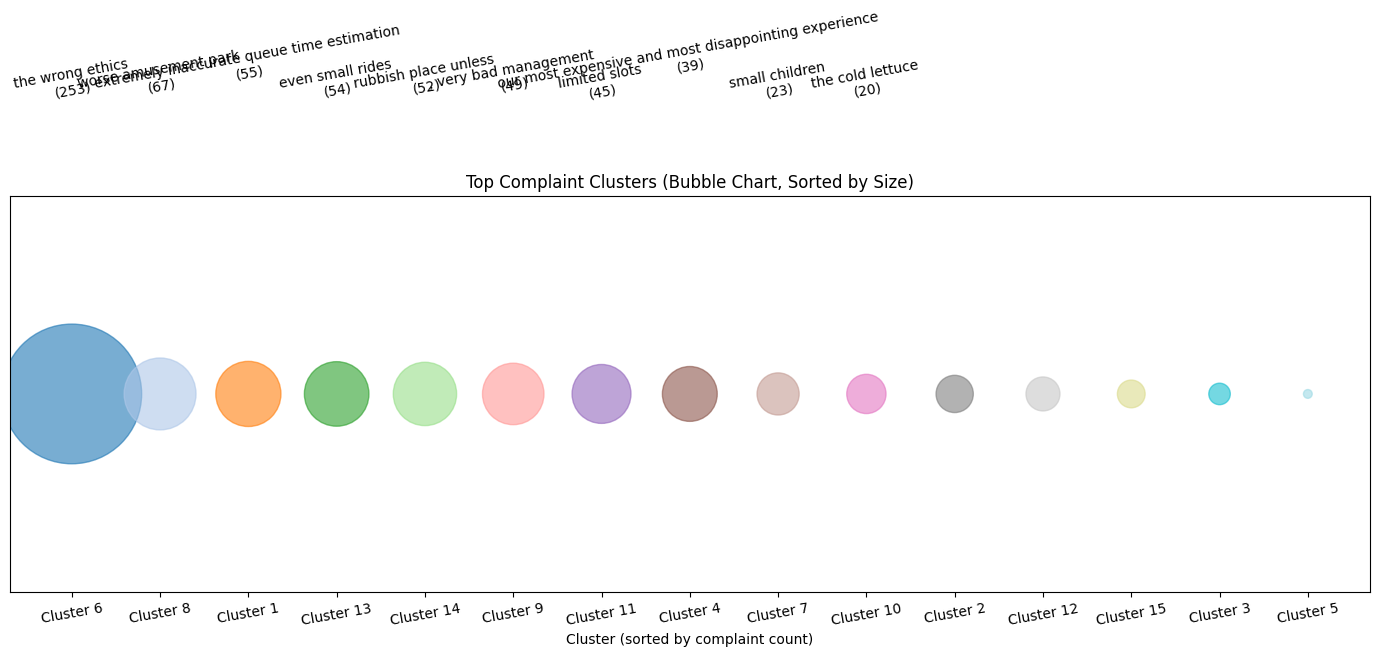

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 收集 cluster 信息
cluster_data = []
for i, (rep, count) in enumerate(zip(rep_phrases, cluster_counts)):
    cluster_data.append({
        'idx': i+1,
        'rep_phrase': rep,
        'count': count
    })

# 2. 按 count 降序排序
cluster_data = sorted(cluster_data, key=lambda x: x['count'], reverse=True)

# 3. 生成泡泡图数据
x = np.arange(1, num_clusters+1)
y = np.ones(num_clusters)
sizes = [d['count'] * 40 for d in cluster_data]
colors = range(num_clusters)
rep_phrases_sorted = [d['rep_phrase'] for d in cluster_data]
counts_sorted = [d['count'] for d in cluster_data]
cluster_names_sorted = [f"Cluster {d['idx']}" for d in cluster_data]

# 4. 画泡泡图
plt.figure(figsize=(14, 7))
scatter = plt.scatter(x, y, s=sizes, c=colors, alpha=0.6, cmap='tab20')

# 标签更紧凑、只显示前10大
for i, (xx, rep, count) in enumerate(zip(x, rep_phrases_sorted, counts_sorted)):
    if count > 0 and i < 10:  # 只标前10大
        plt.text(xx, 1.08, f"{rep}\n({count})", ha='center', va='bottom', fontsize=10, rotation=10)

plt.yticks([])
plt.xticks(x, cluster_names_sorted, rotation=10)
plt.title('Top Complaint Clusters (Bubble Chart, Sorted by Size)')
plt.xlabel('Cluster (sorted by complaint count)')
plt.tight_layout()
plt.show()


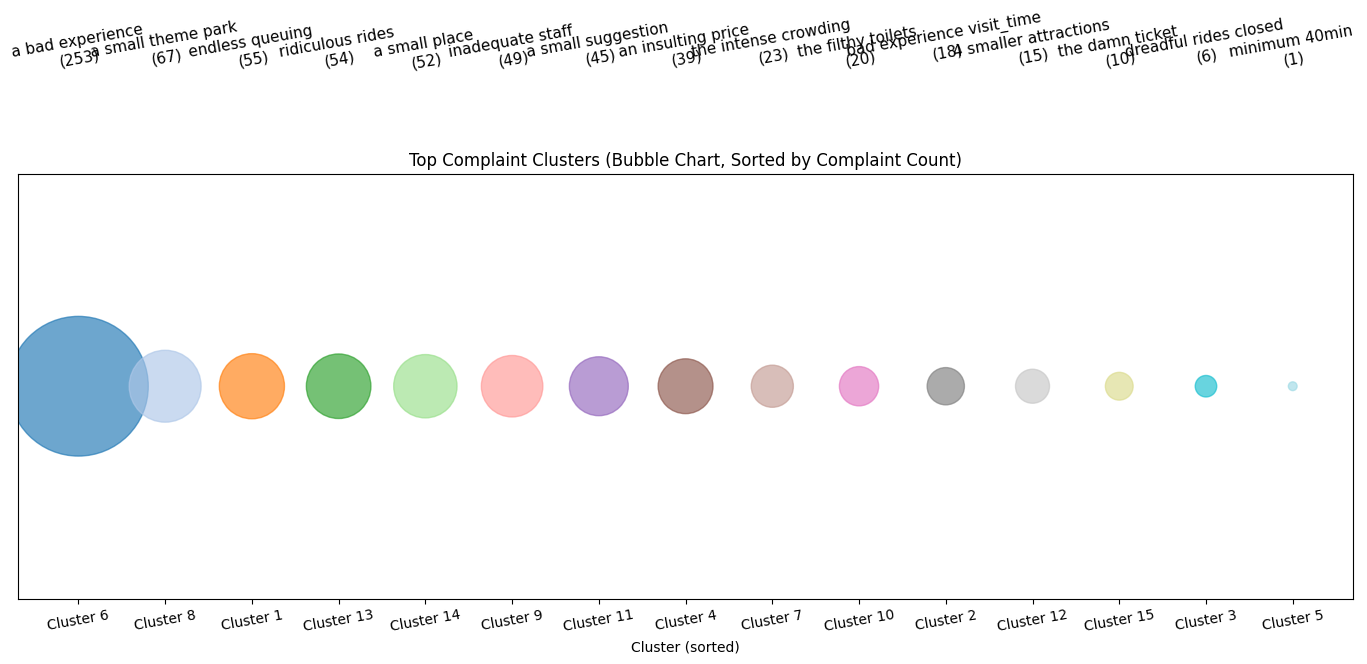

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 统计每个cluster的负面adj+noun数量与代表短语
cluster_info = []
for cluster_id in range(num_clusters):
    cluster_phrases = [p for i, p in enumerate(all_for_cluster) if labels[i] == cluster_id]
    adj_noun_neg = []
    for phrase in cluster_phrases:
        doc = nlp(phrase)
        for i in range(len(doc) - 1):
            if doc[i].pos_ == 'ADJ' and doc[i+1].pos_ == 'NOUN':
                if doc[i].lemma_.lower() in negative_adjs:
                    adj_noun_neg.append(phrase)
                    break
    if adj_noun_neg:
        # 代表短语：离中心最近
        cluster_embeds = [model.encode([p])[0] for p in adj_noun_neg]
        center = kmeans.cluster_centers_[cluster_id].reshape(1, -1)
        dists = cdist(cluster_embeds, center)
        rep_idx = dists.argmin()
        rep_phrase = adj_noun_neg[rep_idx]
    else:
        rep_phrase = ""
    cluster_info.append({
        'cluster_id': cluster_id + 1,
        'rep_phrase': rep_phrase,
        'count': len(adj_noun_neg),
    })

# 排序
cluster_info_sorted = sorted(cluster_info, key=lambda d: d['count'], reverse=True)

# 画气泡图
x = np.arange(1, num_clusters+1)
sizes = [d['count'] * 40 for d in cluster_info_sorted]
colors = range(num_clusters)
rep_phrases_sorted = [d['rep_phrase'] for d in cluster_info_sorted]
counts_sorted = [d['count'] for d in cluster_info_sorted]
cluster_names_sorted = [f"Cluster {d['cluster_id']}" for d in cluster_info_sorted]

plt.figure(figsize=(14, 7))
scatter = plt.scatter(x, np.ones_like(x), s=sizes, c=colors, alpha=0.65, cmap='tab20')

# 只显示前15大
for i, (xx, rep, count) in enumerate(zip(x, rep_phrases_sorted, counts_sorted)):
    if count > 0 and i < 15:
        plt.text(xx, 1.08, f"{rep}\n({count})", ha='center', va='bottom', fontsize=11, rotation=10)

plt.yticks([])
plt.xticks(x, cluster_names_sorted, rotation=10)
plt.title('Top Complaint Clusters (Bubble Chart, Sorted by Complaint Count)')
plt.xlabel('Cluster (sorted)')
plt.tight_layout()
plt.show()


# **🔍 Try 1: BERTopic (❌ Not Selected – Insufficient Granularity)**

	1.	Lack of Granularity:
BERTopic is more suitable for extracting high-level themes (e.g., queuing, staff attitude, ticketing issues), whereas our project specifically aims to extract concrete, fine-grained, and actionable complaint phrases (e.g., worst experience, bad food, minimum waiting time). These critical expressions often appear only a few times within a broad topic and can easily get diluted.

	2.	No Sentiment Filtering Mechanism:
BERTopic does not consider emotional intensity or polarity, making it difficult to focus on strongly negative expressions. Although we tried to filter phrases post hoc using the NRC lexicon, this adds complexity and is prone to omissions.

	3.	Weaker Phrase Representativeness:
Topic keywords in BERTopic are selected based on frequency and embedding distribution, which often results in overly generic terms (e.g., the, and, to). The topic labels are thus less informative, and the model lacks an automated way to highlight representative complaint phrases.

In [ ]:
# Colab里直接运行：安装bertopic和sentence-transformers依赖
!pip install bertopic[all] --quiet
!python -m spacy download en_core_web_sm
!pip install bertopic --quiet
!pip install sentence-transformers --quiet
!pip install umap-learn hdbscan --quiet
!python -m spacy download en_core_web_sm


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import spacy
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from collections import defaultdict

# ========== 步骤1：准备数据和工具 ==========
# 假设文件有 'rating' 和 'integrated_review' 两列
df = pd.read_csv('/content/drive/MyDrive/SMU_MITB_NLP/Groupproject/USS_Reviews_Silver_cleaned_l2.csv')
df_low = df[df['stars'].isin([1, 2])]  # 你的文件如果不是stars就换成rating
texts = df_low['integrated_review'].dropna().astype(str).tolist()
print(f"低分评论总数：{len(texts)}")

# 载入Spacy模型
nlp = spacy.load('en_core_web_sm')

# ========== 步骤2：加载NRC负面形容词 ==========
nrc_path = '/content/drive/MyDrive/SMU_MITB_NLP/Groupproject/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
negative_adjs = set()
with open(nrc_path, encoding='utf-8') as f:
    for line in f:
        word, emotion, flag = line.strip().split('\t')
        if int(flag) == 1 and emotion == 'negative':
            negative_adjs.add(word)

# ========== 步骤3：训练 BERTopic 模型 ==========
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic(embedding_model=sentence_model, top_n_words=10, language='english', verbose=True)
topics, _ = topic_model.fit_transform(texts)
print(f"主题数：{len(set(topics)) - (1 if -1 in topics else 0)}")

# ========== 步骤4：分主题抽取负面 adj+noun 高频短语 ==========
def is_brand_or_location(phrase):
    doc = nlp(phrase)
    for ent in doc.ents:
        if ent.label_ in ['ORG', 'GPE', 'LOC', 'PRODUCT', 'FAC']:
            return True
    bad_keywords = ['uss', 'universal', 'studios', 'sentosa', 'disney', 'singapore']
    return any(bad in phrase.lower() for bad in bad_keywords)

topic_to_texts = defaultdict(list)
for txt, topic in zip(texts, topics):
    if topic != -1:
        topic_to_texts[topic].append(txt)

print("\n—— BERTopic主题下Top负面adj+noun短语汇总 ——")
for topic_id, text_list in topic_to_texts.items():
    # 拼接本主题所有文本
    joined = " ".join(text_list)
    doc = nlp(joined)
    phrase_counts = defaultdict(int)
    for chunk in doc.noun_chunks:
        tokens = list(chunk)
        if len(tokens) >= 2 and tokens[0].pos_ == 'ADJ' and tokens[1].pos_ == 'NOUN':
            if tokens[0].lemma_.lower() in negative_adjs:
                phrase = chunk.text.lower().strip()
                if not is_brand_or_location(phrase):
                    phrase_counts[phrase] += 1
    # 输出每个主题最常见的前5个负面adj+noun短语
    top_phrases = sorted(phrase_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    if top_phrases:
        topic_words = ", ".join([w for w, _ in topic_model.get_topic(topic_id)])
        print(f"\n[Topic {topic_id}] 主题关键词：{topic_words}")
        for phrase, count in top_phrases:
            print(f"  - {phrase} （{count}次）")


低分评论总数：2107


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-06-18 01:42:33,606 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/66 [00:00<?, ?it/s]

2025-06-18 01:42:35,052 - BERTopic - Embedding - Completed ✓
2025-06-18 01:42:35,052 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-18 01:42:47,232 - BERTopic - Dimensionality - Completed ✓
2025-06-18 01:42:47,233 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-18 01:42:47,318 - BERTopic - Cluster - Completed ✓
2025-06-18 01:42:47,322 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-18 01:42:47,441 - BERTopic - Representation - Completed ✓


主题数：30

—— BERTopic主题下Top负面adj+noun短语汇总 ——

[Topic 0] 主题关键词：singapore, the, to, in, and, of, universal, for, was, it
  - worst experience （6次）
  - worst place （3次）
  - inferior versions （3次）
  - limited budget or vegetarian options （1次）
  - worst customer service （1次）

[Topic 9] 主题关键词：staff, rude, the, me, and, to, my, at, attitude, of
  - pathetic experience （1次）
  - tough language （1次）
  - terrible customer service （1次）
  - grumpy face （1次）
  - bad attitude （1次）

[Topic 3] 主题关键词：universal, studios, the, and, is, to, it, of, rides, not
  - worst experience （2次）
  - small kids （1次）
  - limited ride options （1次）
  - bad management （1次）
  - inadequate seating （1次）

[Topic 8] 主题关键词：visit_time, wait_time, weekday, min, hr, too, weekend, wait, 3060, long
  - bad service （1次）
  - inefficient handling （1次）

[Topic 11] 主题关键词：you, the, express, for, to, is, park, and, of, not
  - minimum 1hr （1次）
  - tired feet （1次）
  - worst park planning （1次）
  - atrocious price （1次）
  - endless queues （1次）



# 🔍 **Try 2: NRC-Guided Adj+Noun Filtering + Theme Dictionary Mapping + Clustering on ‘Other’ (⚠️ Moderate Results)**

In [ ]:
# 若在 Colab 或首次运行，先安装依赖（只需运行一次即可）
!pip install keybert sentence-transformers spacy
!python -m spacy download en_core_web_sm

import pandas as pd
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from keybert import KeyBERT

# 1. 读取原始数据
file_path = '/content/drive/MyDrive/SMU_MITB_NLP/Groupproject/USS_Reviews_Silver_cleaned_l2.csv'
df = pd.read_csv(file_path)
texts = df[df['stars'].isin([1, 2])]['integrated_review'].dropna().astype(str).tolist()
print(f"共采集{len(texts)}条1-2星评论")

# 2. spaCy辅助
nlp = spacy.load('en_core_web_sm')
def is_brand_or_location(phrase):
    doc = nlp(phrase)
    for ent in doc.ents:
        if ent.label_ in ['ORG', 'GPE', 'LOC', 'PRODUCT', 'FAC']:
            return True
    bad_keywords = ['uss', 'universal', 'studios', 'sentosa', 'disney', 'singapore']
    return any(bad in phrase.lower() for bad in bad_keywords)

# 3. NRC负面adj
nrc_path = '/content/drive/MyDrive/SMU_MITB_NLP/Groupproject/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
negative_adjs = set()
with open(nrc_path, encoding='utf-8') as f:
    for line in f:
        word, emotion, flag = line.strip().split('\t')
        if int(flag) == 1 and emotion == 'negative':
            negative_adjs.add(word.lower())

# 4. KeyBERT + noun_chunks抽短语
kw_model = KeyBERT('all-mpnet-base-v2')
all_keybert_phrases = []
for text in texts:
    phrases = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(2, 3),
        stop_words='english',
        top_n=3
    )
    all_keybert_phrases.extend([kw[0] for kw in phrases])

all_keybert_phrases = [p for p in set(all_keybert_phrases) if not is_brand_or_location(p)]

all_noun_phrases = []
for text in texts:
    doc = nlp(text)
    all_noun_phrases += [chunk.text.lower().strip() for chunk in doc.noun_chunks if not is_brand_or_location(chunk.text)]

all_noun_phrases = list(set(all_noun_phrases))

# 合并短语集合
all_phrases = list(set(all_noun_phrases + all_keybert_phrases))
print(f"合并去重后短语数：{len(all_phrases)}")

# 5. 只保留负面adj+noun短语
adj_noun_neg_phrases = []
for phrase in all_phrases:
    doc = nlp(phrase)
    for i in range(len(doc) - 1):
        if doc[i].pos_ == 'ADJ' and doc[i+1].pos_ == 'NOUN':
            if doc[i].lemma_.lower() in negative_adjs:
                adj_noun_neg_phrases.append(phrase)
                break
print(f"有效负面adj+noun短语数：{len(adj_noun_neg_phrases)}")

# 6. 主题映射表
theme_map = {
    "Minions": ["Minions", "Minions ride", "Minion attraction"],
    "Sesame Street": ["Sesame Street", "Sesame Street ride", "Sesame Street attraction"],
    "Transformers": ["Transformers", "Transformers ride", "Transformers attraction"],
    "The Mummy": ["The Mummy", "The Mummy ride", "The Mummy attraction"],
    "Jurassic Park": ["Jurassic Park", "Jurassic Park ride", "Jurassic Park attraction", "JP ride", "Jurassic Park Rapids"],
    "Shrek": ["Shrek", "Shrek ride", "Shrek attraction"],

    # Facilities & Services
    "locker": ["locker", "lockers", "locker rental"],
    "restroom": ["restroom", "restrooms", "toilet", "washroom", "bathroom"],
    "restaurant": ["restaurant", "restaurants", "food court", "dining", "eatery"],
    "first aid": ["first aid"],
    "baby care": ["baby care"],
    "child swap": ["child swap"],
    "stroller and wheelchair rental": ["stroller and wheelchair rental"],
    "guest services": ["guest services"],
    "retail outlets": ["retail outlets"],
    "prayer room": ["prayer room"],
    "smoking area": ["smoking area", "smoking areas"],
    "accessible parking": ["accessible parking"],
    "shuttle service": ["shuttle service"],
    "charging station": ["charging station", "charging stations"],
    "wifi": ["wifi", "wi-fi"],
    "express": ["express", "express pass", "fast pass", "VIP pass"],

    # New categories
    "food options": ["food", "meals", "snacks", "beverage", "drinks", "ice cream", "lunch", "dinner"],
    "customer service": ["customer service", "staff help", "help desk", "assistance", "service quality"],
    "wait times": ["wait time", "waiting time", "long queue", "queue time", "delay", "slow line"],
    "bad attitude": ["rude staff", "unfriendly staff", "bad attitude", "impolite", "not helpful"],
    "crowd management": ["crowd", "overcrowded", "too many people", "crowd control", "crowd management"]
}
theme_flat = {}
for theme, variants in theme_map.items():
    for v in variants:
        theme_flat[v.lower()] = theme

def map_to_theme(phrase):
    phrase_lower = phrase.lower()
    for v in theme_flat.keys():
        if v in phrase_lower:
            return theme_flat[v]
    return "other"

mapped_theme = [map_to_theme(p) for p in adj_noun_neg_phrases]
print("\n按主题词典归类后分布：")
print(pd.Series(mapped_theme).value_counts().head(12))

# 7. 对“other”短语自动聚类发现新主题
other_phrases = [p for p, t in zip(adj_noun_neg_phrases, mapped_theme) if t == "other"]
print(f"\n需要聚类的other类短语数量: {len(other_phrases)}")

if other_phrases:
    model = SentenceTransformer('all-mpnet-base-v2')
    other_emb = model.encode(other_phrases)
    num_clusters = 8
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(other_emb)
    for cluster_id in range(num_clusters):
        idxs = [i for i, l in enumerate(labels) if l == cluster_id]
        c_phrases = [other_phrases[i] for i in idxs]
        if not c_phrases:
            continue
        # 代表短语：离中心最近
        cluster_embeds = [other_emb[i] for i in idxs]
        center = kmeans.cluster_centers_[cluster_id].reshape(1, -1)
        dists = cdist(cluster_embeds, center)
        rep_idx = dists.argmin()
        print(f"\nOther-Cluster {cluster_id+1}【代表短语】{c_phrases[rep_idx]}")
        print(f"   同簇短语共{len(c_phrases)}条，示例: {c_phrases[:5]} ...")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 129.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
共采集2107条1-2星评论


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

合并去重后短语数：14871
有效负面adj+noun短语数：707

按主题词典归类后分布：
other               636
food options         17
wait times           14
crowd management     11
bad attitude          8
restaurant            7
Transformers          4
customer service      4
restroom              4
express               1
locker                1
Name: count, dtype: int64

需要聚类的other类短语数量: 636

Other-Cluster 1【代表短语】unbearable queues
   同簇短语共41条，示例: ['bad experience waiting', 'such an inefficient checkout process', 'worst experience waiting', 'mins worse queue', 'the wrong queue'] ...

Other-Cluster 2【代表短语】horrible place
   同簇短语共28条，示例: ['a terrible state', 'awful place dont', 'useless place jurassic', 'awful place', 'horrible place'] ...

Other-Cluster 3【代表短语】a bad day
   同簇短语共153条，示例: ['ridiculous line', 'the cold lettuce', 'terrible memory', 'bad photos visit_time', 'a tough situation'] ...

Other-Cluster 4【代表短语】bad management
   同簇短语共129条，示例: ['pathetic conduct', 'a blatant money making scheme', 'unknown reasons', 'a r

# ⚠️ **Issue Identified: Overly Generic or Template-Like Phrases**
Currently, some noun phrases extracted via noun_chunks and KeyBERT are overly generic or template-based — e.g., *"bad experience"*, *"small place"*, *"limited number"*.  
These phrases lack specific actionable insights and carry low information density.  
We aim to avoid such vague expressions and focus on more concrete, context-rich complaints.

# **Solution 1 for Noun Phrases: Entity-Aware Enhancement (NER + Dependency Rules)**

In [ ]:
import pandas as pd
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from keybert import KeyBERT

# 1. 评论文本
texts = df_low['integrated_review'].dropna().astype(str).tolist()
nlp = spacy.load('en_core_web_sm')

def is_brand_or_location(phrase):
    doc = nlp(phrase)
    for ent in doc.ents:
        if ent.label_ in ['ORG', 'GPE', 'LOC', 'PRODUCT', 'FAC']:
            return True
    bad_keywords = ['uss', 'universal', 'studios', 'sentosa', 'disney', 'singapore']
    return any(bad in phrase.lower() for bad in bad_keywords)

# 2. NRC负面形容词
nrc_path = '/content/drive/MyDrive/SMU_MITB_NLP/Groupproject/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
negative_adjs = set()
with open(nrc_path, encoding='utf-8') as f:
    for line in f:
        word, emotion, flag = line.strip().split('\t')
        if int(flag) == 1 and emotion == 'negative':
            negative_adjs.add(word)

# 3. KeyBERT抽取短语
kw_model = KeyBERT('all-mpnet-base-v2')
all_keybert_phrases = []
for text in texts:
    phrases = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(2, 3),
        stop_words='english',
        top_n=3
    )
    all_keybert_phrases.extend([kw[0] for kw in phrases])
all_keybert_phrases = [p for p in set(all_keybert_phrases) if not is_brand_or_location(p)]

# noun_chunks
all_noun_phrases = []
for text in texts:
    doc = nlp(text)
    all_noun_phrases += [chunk.text.lower().strip() for chunk in doc.noun_chunks if not is_brand_or_location(chunk.text)]
all_noun_phrases = list(set(all_noun_phrases))

# =========== Step A: 抓实体作为精确名词短语 ===========
def extract_entities(text):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        if ent.label_ in ['PRODUCT', 'FAC', 'ORG', 'EVENT', 'WORK_OF_ART']:
            if not is_brand_or_location(ent.text):
                entities.append(ent.text.lower().strip())
    return entities

all_entities = []
for text in texts:
    all_entities += extract_entities(text)
all_entities = list(set(all_entities))

# =========== Step B: 加自定义词典 ===========
custom_facilities = ['minion ride', 'transformers ride', 'jurassic park', 'express ticket', 'revenge of the mummy', 'roller coaster', 'locker', 'popcorn', 'chicken rice', 'waterworld', 'souvenir shop', 'staff', 'toilet', 'hollywood zone']

# =========== Step C: 合并所有池，做“对象”短语增强 ===========
def is_concrete_noun(phrase):
    stopwords = ['experience', 'day', 'time', 'service', 'thing', 'area', 'event', 'stuff', 'visit', 'review', 'something', 'anything', 'everything']
    for sw in stopwords:
        if sw in phrase:
            return False
    doc = nlp(phrase)
    if 1 < len(doc) <= 5 and all(t.pos_ in ['NOUN', 'PROPN'] for t in doc):
        return True
    if phrase in all_entities or phrase in custom_facilities:
        return True
    return False

# 用增强后的池替换掉之前的 all_for_cluster
all_for_cluster = list(set([
    phrase for phrase in (all_noun_phrases + all_keybert_phrases + all_entities + custom_facilities)
    if is_concrete_noun(phrase)
]))

# =========== 聚类与输出 ===========
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(all_for_cluster)
num_clusters = min(15, max(2, len(all_for_cluster) // 5))
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(embeddings)
labels = kmeans.labels_

print("\n—— 每簇cluster中的精确抱怨对象短语（每簇仅输出代表短语+全部短语）——")
for cluster_id in range(num_clusters):
    cluster_phrases = [p for i, p in enumerate(all_for_cluster) if labels[i] == cluster_id]
    if not cluster_phrases:
        continue
    cluster_embeds = [model.encode([p])[0] for p in cluster_phrases]
    center = kmeans.cluster_centers_[cluster_id].reshape(1, -1)
    dists = cdist(cluster_embeds, center)
    rep_idx = dists.argmin()
    print(f"\nCluster {cluster_id+1}: {cluster_phrases[rep_idx]} (代表短语)")
    print(f"    同簇具体抱怨对象短语: {cluster_phrases}")



—— 每簇cluster中的精确抱怨对象短语（每簇仅输出代表短语+全部短语）——

Cluster 1: roller coaster (代表短语)
    同簇具体抱怨对象短语: ['crazy rides', 'coaster styles', 'cyon roller coast', 'ride lot tourists', 'ride operators', 'fun roller coasters', 'nice roller coasters', 'cookie monster ride', 'cylon rollercoaster', 'hour roller ride', 'hour ride', 'aren roller coasters', '1hr ride pricey', 'roller coasters destination', 'family great rides', 'battlestar galactica roller', 'shame thrilling rides', 'management ride', 'cylon ride', 'roller coaster battlestar', 'rollercoaster tycoon', 'maximum ride', 'fun ride spend', 'roller coaster entertainment', 'spaghetti ride', 'treasure hunt ride', 'ride activities', 'mediocre rides', 'thriller rollercoasters', 'galactica roller coaster', 'rollercoaster place', 'rides crowd management', 'rides closed rides', 'children awesome rides', 'roller ride places', 'love ride', 'fun ride qqq', 'fun roller coaster', 'adventure ride minions', 'ride hour', 'battlestar roller coasters', 'jp ride expr

# **Solution 2 for Noun Phrases:Tried Upgrading to `en_core_web_trf` — But Stuck with `en_core_web_sm` for Better Task Fit**

### 🆚 Comparing spaCy Models: `en_core_web_sm` vs `en_core_web_trf`

| Feature | `en_core_web_sm` | `en_core_web_trf` |
|--------|------------------|-------------------|
| **Model Type** | Lightweight, statistical | Transformer-based (e.g., RoBERTa) |
| **NER Accuracy** | Basic, may miss finer-grained entities | High, recognizes specific objects (e.g., facilities, food)  |
| **Speed** | Fast  | Slower |
| **RAM Usage** | Low (Colab-safe) | High (may require High-RAM Colab runtime) |
| **Installation** | Pre-installed in spaCy | Requires `spacy-transformers` + `en_core_web_trf` model |
| **Phrase Specificity** | Often returns vague terms like `"bad experience"` | Captures precise entities like `"locker"`, `"souvenir shop"`  |
| **Use Case Suitability** | Rapid prototyping, quick tests | High-precision entity-aware phrase extraction  |

🔁 Although **`en_core_web_trf`** is theoretically a more powerful transformer-based model, we observed that **`en_core_web_sm`** produced better results for our specific task.  
This reflects a classic *task-oriented trade-off* — instead of choosing the "larger" model, we prioritized the one that aligns best with our extraction goals.

⚠️ As a result, we **finally reverted to `en_core_web_sm`** as our final choice — the same lightweight model we started with — due to its superior performance in generating clear, syntactic ADJ + NOUN phrases that align well with our complaint phrase pipeline.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_trf')

!python -m spacy download en_core_web_trf

import pandas as pd
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from keybert import KeyBERT

# 1. 评论文本
texts = df_low['integrated_review'].dropna().astype(str).tolist()
# 加载 transformer 版 NER，首次用需 pip install spacy-transformers; python -m spacy download en_core_web_trf
nlp = spacy.load('en_core_web_trf') #spaCy的 transformer 大模型（_trf，底层是 RoBERTa/Transformer，精度高，能识别更细粒度实体，慢且内存大）。

def is_brand_or_location(phrase):
    doc = nlp(phrase)
    for ent in doc.ents:
        if ent.label_ in ['ORG', 'GPE', 'LOC', 'PRODUCT', 'FAC']:
            return True
    bad_keywords = ['uss', 'universal', 'studios', 'sentosa', 'disney', 'singapore']
    return any(bad in phrase.lower() for bad in bad_keywords)

# 2. NRC负面形容词
nrc_path = '/content/drive/MyDrive/SMU_MITB_NLP/Groupproject/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
negative_adjs = set()
with open(nrc_path, encoding='utf-8') as f:
    for line in f:
        word, emotion, flag = line.strip().split('\t')
        if int(flag) == 1 and emotion == 'negative':
            negative_adjs.add(word)

# 3. KeyBERT抽取短语
kw_model = KeyBERT('all-mpnet-base-v2')
all_keybert_phrases = []
for text in texts:
    phrases = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(2, 3),
        stop_words='english',
        top_n=3
    )
    all_keybert_phrases.extend([kw[0] for kw in phrases])
all_keybert_phrases = [p for p in set(all_keybert_phrases) if not is_brand_or_location(p)]

# noun_chunks
all_noun_phrases = []
for text in texts:
    doc = nlp(text)
    all_noun_phrases += [chunk.text.lower().strip() for chunk in doc.noun_chunks if not is_brand_or_location(chunk.text)]
all_noun_phrases = list(set(all_noun_phrases))

# **NER抽取设施/产品/组织/地点等具体实体**
all_ner_phrases = []
for text in texts:
    doc = nlp(text)
    all_ner_phrases += [ent.text.lower().strip() for ent in doc.ents if ent.label_ in ['PRODUCT', 'FAC', 'ORG', 'GPE', 'LOC']]
all_ner_phrases = list(set(all_ner_phrases))

# 合并聚类池：三路短语融合，提升精准度
all_for_cluster = list(set(all_noun_phrases + all_keybert_phrases + all_ner_phrases))

# 聚类+输出（同前）
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(all_for_cluster)

num_clusters = 15
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(embeddings)
labels = kmeans.labels_

print("\n—— 每簇cluster中的NRC负面adj+noun高质量抱怨短语（每簇仅输出代表短语+全部短语）——")
for cluster_id in range(num_clusters):
    cluster_phrases = [p for i, p in enumerate(all_for_cluster) if labels[i] == cluster_id]
    # 只保留 adj+noun 且adj在负面情感词里的短语
    adj_noun_neg = []
    for phrase in cluster_phrases:
        doc = nlp(phrase)
        for i in range(len(doc) - 1):
            if doc[i].pos_ == 'ADJ' and doc[i+1].pos_ == 'NOUN':
                if doc[i].lemma_.lower() in negative_adjs:
                    adj_noun_neg.append(phrase)
                    break
    if not adj_noun_neg:
        continue
    # 代表短语：离中心最近
    cluster_embeds = [model.encode([p])[0] for p in adj_noun_neg]
    center = kmeans.cluster_centers_[cluster_id].reshape(1, -1)
    dists = cdist(cluster_embeds, center)
    rep_idx = dists.argmin()
    print(f"\nCluster {cluster_id+1}: {adj_noun_neg[rep_idx]} (代表短语)")
    print(f"    同簇adj+noun负面短语: {adj_noun_neg}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 2.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



—— 每簇cluster中的NRC负面adj+noun高质量抱怨短语（每簇仅输出代表短语+全部短语）——

Cluster 1: a not bad experience (代表短语)
    同簇adj+noun负面短语: ['a very bad birthday experience', 'small fun', 'most pathetic experience', 'a very disappointing experience', 'a very unpleasant experience', 'disappointing terms excitement', 'a worst experience', 'very bad experiences', 'overall though, not a bad experience', 'a horrible day', 'small fun good', 'truly disappointing trip', 'a very expensive disappointing day', 'small fun definitely', 'bad experience', 'worst day', 'such a bad experience', 'some dangerous games', 'a more intense adventure', 'pathetic experience', 'a crazy day', 'a terrible time', 'a boring thing', 'expensive disappointing experience', 'terrible day', 'overall a very very bad experience', 'overall unsatisfactory experience', 'ridiculous events', 'my worse experiences', 'an intense action sequence', 'the worst visit', 'very very worst experience', 'an exhauting and disappointing day', 'terrible experience', 

In [ ]:
import pandas as pd
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from keybert import KeyBERT

# 1. 评论文本
texts = df_low['integrated_review'].dropna().astype(str).tolist()
nlp = spacy.load('en_core_web_sm')

def is_brand_or_location(phrase):
    doc = nlp(phrase)
    for ent in doc.ents:
        if ent.label_ in ['ORG', 'GPE', 'LOC', 'PRODUCT', 'FAC']:
            return True
    bad_keywords = ['uss', 'universal', 'studios', 'sentosa', 'disney', 'singapore']
    return any(bad in phrase.lower() for bad in bad_keywords)

# 2. 负面形容词表
nrc_path = '/content/drive/MyDrive/SMU_MITB_NLP/Groupproject/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
negative_adjs = set()
with open(nrc_path, encoding='utf-8') as f:
    for line in f:
        word, emotion, flag = line.strip().split('\t')
        if int(flag) == 1 and emotion == 'negative':
            negative_adjs.add(word)

# 3. 大池子：KeyBERT和noun_chunk
kw_model = KeyBERT('all-mpnet-base-v2')
all_keybert_phrases = []
for text in texts:
    phrases = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(2, 4),
        stop_words='english',
        top_n=3
    )
    all_keybert_phrases.extend([kw[0] for kw in phrases])
all_keybert_phrases = [p for p in set(all_keybert_phrases) if not is_brand_or_location(p)]

all_noun_phrases = []
for text in texts:
    doc = nlp(text)
    all_noun_phrases += [chunk.text.lower().strip() for chunk in doc.noun_chunks if not is_brand_or_location(chunk.text)]
all_noun_phrases = list(set(all_noun_phrases))

# 4. 合并大池子
all_phrases = list(set(all_keybert_phrases + all_noun_phrases))

# 5. 只保留负面adj+noun短语
adj_noun_neg = []
for phrase in all_phrases:
    doc = nlp(phrase)
    for i in range(len(doc) - 1):
        if doc[i].pos_ == 'ADJ' and doc[i+1].pos_ == 'NOUN':
            if doc[i].lemma_.lower() in negative_adjs:
                adj_noun_neg.append(phrase)
                break
# 如果太少，可以适当放宽KeyBERT短语长度（比如ngram=2,4），或把noun_chunk长度适当放宽

adj_noun_neg = list(set(adj_noun_neg))
if not adj_noun_neg:
    print("未找到负面adj+noun短语，请适当调整池子或形容词词典！")

# 6. 聚类（只对这些complaint短语聚类）
if len(adj_noun_neg) < 2:
    print("聚类短语过少，暂不聚类")
else:
    model = SentenceTransformer('all-mpnet-base-v2')
    embeddings = model.encode(adj_noun_neg)
    num_clusters = min(10, max(2, len(adj_noun_neg) // 5))
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(embeddings)
    labels = kmeans.labels_

    print("\n—— 每簇cluster中的负面adj+noun抱怨短语（每簇仅输出代表短语+全部短语）——")
    for cluster_id in range(num_clusters):
        cluster_phrases = [p for i, p in enumerate(adj_noun_neg) if labels[i] == cluster_id]
        if not cluster_phrases:
            continue
        cluster_embeds = [model.encode([p])[0] for p in cluster_phrases]
        center = kmeans.cluster_centers_[cluster_id].reshape(1, -1)
        dists = cdist(cluster_embeds, center)
        rep_idx = dists.argmin()
        print(f"\nCluster {cluster_id+1}: {cluster_phrases[rep_idx]} (代表短语)")
        print(f"    同簇complaint短语: {cluster_phrases}")



—— 每簇cluster中的负面adj+noun抱怨短语（每簇仅输出代表短语+全部短语）——

Cluster 1: bad weather (代表短语)
    同簇complaint短语: ['insufficient shelter', 'the weird tornado', 'covid worst time', 'late time', 'the lost world show', 'games bad weather', 'a horribly uncomfortable day', 'dull eventsits', 'unreliable words chritmas', 'an exhauting and disappointing day', 'inexplicable reasons', 'unknown reasons', 'the lost word', 'a fake environment', 'transformers busier late afternoon', 'bad weather', 'expected bad weather', 'heavy rain stupid workers', 'the lost world', 'its not a cheap day', 'outstanding architecture', 'broken devices', 'an intense throwback', 'more intense games', 'an intense action sequence', 'intense humidity', 'the late opening', 'fun bad weather hot', 'a gloomy day', 'endless lines', 'tired and cranky kids', 'some dangerous games', 'the smaller faults', '"suspicious transaction', 'shady spots', 'the lost hour', 'the late mornings', 'its unpredictable movements', 'the late afternoon', 'an unknown

# **Solution 3 for Noun Phrases:: LLM-Based Extraction of Complaint Target–Content Pairs (e.g., GPT-4) — ❌ Not Used Due to API Limitations**

In [ ]:
!pip install --upgrade openai



# **Base Pre-trained Model Selection: KeyBERT + E5-large / GTE-large / all-mpnet-base-v2 (3 choose 1)**

Why choose all-mpnet-base-v2 (instead of GTE-large / E5-large)?

| Model Name         | Accuracy | Computational Efficiency | Characteristics                                                                 |
|--------------------|----------|----------------------------|----------------------------------------------------------------------------------|
| all-mpnet-base-v2  | ⭐⭐⭐⭐⭐   | ⭐⭐⭐⭐⭐                     | Suitable for general reviews, strong representation ability and fast computation |
| GTE-large          | ⭐⭐⭐⭐⭐   | ⭐⭐                        | Open-sourced by Google, good for QA and dialogue search, suits technical scenarios |
| E5-large           | ⭐⭐⭐⭐    | ⭐⭐                        | Optimized for retrieval, suitable for vector search and semantic matching        |

	•	mpnet performs consistently well on review-style texts. It handles subjective expressions and short text understanding effectively, with moderate embedding size and lower computational cost — making it ideal for your Colab project.
	•	While E5 and GTE perform well in retrieval tasks, they may overfit to structured language or be overly sensitive to abstract terms in non-retrieval contexts.
	•	For your objective (“identifying specific complaint phrases”), mpnet is better at capturing everyday, emotionally charged expressions, rather than broad thematic nouns or QA-style semantics.

In [ ]:
import pandas as pd

# rows 是你之前收集所有增强+原文的列表，每一项是字典 {'text':..., 'stars':..., 'publishedAtDate':...}
df_aug = pd.DataFrame(rows).drop_duplicates(subset=['text'])
df_aug.to_csv('/content/drive/MyDrive/SMU_MITB_NLP/Groupproject/augmented_reviews_with_meta.csv', index=False)
print("已保存增强数据到 /content/drive/MyDrive/SMU_MITB_NLP/Groupproject/augmented_reviews_with_meta.csv")


已保存增强数据到 /content/drive/MyDrive/SMU_MITB_NLP/Groupproject/augmented_reviews_with_meta.csv


# **｜KeyBERT + all-mpnet-base-v2**





In [ ]:
# 1. 安装KeyBERT和Sentence Transformers
!pip install keybert
!pip install sentence-transformers

# 2. 导入所需库
from keybert import KeyBERT
import pandas as pd
from collections import Counter

# 3. 读取增强后的评论数据
aug_path = '/content/drive/MyDrive/SMU_MITB_NLP/Groupproject/augmented_reviews_with_meta.csv'
df_aug = pd.read_csv(aug_path)
texts = df_aug['text'].astype(str).tolist()

# 4. 初始化KeyBERT，使用all-mpnet-base-v2作为嵌入模型
kw_model = KeyBERT('all-mpnet-base-v2')

# 5. 批量抽取短语
all_phrases = []
for text in texts:
    # 2-4词短语，每条评论取top2，参数可调
    phrases = [kw[0] for kw in kw_model.extract_keywords(text, keyphrase_ngram_range=(2, 4), top_n=2)]
    all_phrases.extend(phrases)

# 6. 统计高频短语，输出Top 30 complaints
top30 = Counter(all_phrases).most_common(30)
print("—— Top 30 Complaint Phrases ——")
for i, (phrase, cnt) in enumerate(top30, 1):
    print(f"{i}. {phrase} ({cnt})")


—— Top 30 Complaint Phrases ——
1. rides closed (41)
2. universal studios singapore (34)
3. visit_time weekday wait_time (31)
4. visit_time weekday wait_time 3060 (24)
5. attractions closed (23)
6. theme park (22)
7. visit_time weekday wait_time 1030 (22)
8. worst theme park (21)
9. visit_time weekend wait_time (18)
10. visit universal studios (17)
11. visit_time public holiday wait_time (16)
12. transformers ride (14)
13. universal singapore (11)
14. experience universal studios (10)
15. visit_time weekday wait_time hr (10)
16. universal studio (10)
17. visit_time weekday wait_time wait (9)
18. visit universal studios singapore (9)
19. park closed (9)
20. experience universal studios singapore (9)
21. worst universal studios (9)
22. compared universal studios (8)
23. singapore universal studios (8)
24. buy express pass (7)
25. express pass (7)
26. worst amusement park (7)
27. rides visit_time weekday wait_time (7)
28. visit_time weekend wait_time 3060 (7)
29. long queues (7)
30. overpr

# **｜KeyBERT + E5-large/v2（intfloat/企业级检索SOTA）**

In [ ]:
# 1. 安装KeyBERT和sentence-transformers（如果未装可取消注释）
# !pip install keybert
# !pip install sentence-transformers

from keybert import KeyBERT
import pandas as pd
from collections import Counter

# 2. 读取增强后的评论数据
aug_path = '/content/drive/MyDrive/SMU_MITB_NLP/Groupproject/augmented_reviews_with_meta.csv'
df_aug = pd.read_csv(aug_path)
texts = df_aug['text'].astype(str).tolist()

# 3. 初始化KeyBERT，使用企业级 SOTA 嵌入模型 E5-large-v2
kw_model = KeyBERT('intfloat/e5-large-v2')

# 4. 批量抽取短语
all_phrases = []
for text in texts:
    # 每条评论抽取2-4词短语的top2
    phrases = [kw[0] for kw in kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(2, 4),
        top_n=2,
        stop_words='english'  # 可选：自动去掉无意义高频词
    )]
    all_phrases.extend(phrases)

# 5. 统计高频短语，输出Top 30 complaints
top30 = Counter(all_phrases).most_common(30)
print("—— Top 10 Complaint Phrases (E5-large-v2) ——")
for i, (phrase, cnt) in enumerate(top30, 1):
    print(f"{i}. {phrase} ({cnt})")


## 🔍 NRC **Negative Lexicon** Overview

✅ Why We Choose NRC over Other Sentiment Lexicons

We specifically use the negative category from the NRC Emotion Lexicon as an emotional filter for selecting adjective + noun (ADJ + NOUN) complaint phrases.
This approach allows us to:

	•	🎯 Focus on emotionally intense, explicitly negative expressions, rather than neutral or generic noun phrases.
	•	❌ Avoid vague or ambiguous negatives like “not good”, which are often hard to capture using traditional polarity-based lexicons.
	•	💬 Leverage NRC’s large, manually annotated dataset, which provides rich emotional labeling across multiple dimensions.


Compared to other binary sentiment lexicons (e.g., Vader, SentiWordNet), NRC offers clear advantages:

	•	Higher precision in detecting complaint-driven phrases, not just general negativity.
	•	Greater thematic diversity, supporting downstream clustering into categories like anger, fear, and disgust.

In [ ]:
# ... 你的前半部分代码不变 ...

# 1. 读取NRC-Emotion词典到dict
nrc_path = '/content/drive/MyDrive/SMU_MITB_NLP/Groupproject/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
emotion_lexicon = {}  # word -> set of emotions
with open(nrc_path, encoding='utf-8') as f:
    for line in f:
        word, emotion, flag = line.strip().split('\t')
        if int(flag) == 1:
            if word not in emotion_lexicon:
                emotion_lexicon[word] = set()
            emotion_lexicon[word].add(emotion)

# 2. 给短语打多情绪标签（只分析形容词部分的情绪）
nlp = spacy.load('en_core_web_sm')
phrase2emotion = {}
for phrase in set(adj_noun_phrases):
    doc = nlp(phrase)
    if len(doc) >= 2:
        adj = doc[0].lemma_.lower()  # 只分析形容词
        noun = doc[1].lemma_.lower()
        emotions = emotion_lexicon.get(adj, set())
        if emotions:
            phrase2emotion[phrase] = emotions

# 3. 输出带多情绪标签的短语
print("Top complaint phrases with NRC emotion tags:")
for phrase, emotions in phrase2emotion.items():
    print(f"{phrase:30} | {' / '.join(sorted(emotions))}")

# 4. 可选：统计不同情绪下的高频短语
# 可以按 anger/disgust/sadness 分类输出Top短语
from collections import defaultdict
emotion_to_phrases = defaultdict(list)
for phrase, emotions in phrase2emotion.items():
    for emo in emotions:
        emotion_to_phrases[emo].append(phrase)

print("\n—— Top complaints by emotion ——")
for emo in ["anger", "disgust", "sadness", "fear", "negative"]:
    top_phrases = emotion_to_phrases[emo][:10]
    if top_phrases:
        print(f"\n{emo.upper()}:")
        for phrase in top_phrases:
            print(f"  {phrase}")


Top complaint phrases with NRC emotion tags:
worth dollar                   | positive
hot sunburn                    | anger
main rides                     | positive
major roller                   | positive
worst theme                    | anger / disgust / fear / negative / sadness
good theme                     | anticipation / joy / positive / surprise / trust
terrible experience            | anger / disgust / fear / negative / sadness
small boring                   | negative
cool experience                | positive
bad photos                     | anger / disgust / fear / negative / sadness
unlimited tickets              | positive
unlimited pass                 | positive
ready btw                      | anticipation
ridiculous rides               | anger / disgust / negative
major park                     | positive
worst meal                     | anger / disgust / fear / negative / sadness
horrible wait                  | anger / disgust / fear / negative
latest visit     

In [ ]:
# ... 你的前半部分代码不变，直到 adj_noun_phrases 得到 ...

# Step 1: 安装WordNet-Affect相关工具
!pip install git+https://github.com/valeriobasile/pywn-affect.git
import nltk
nltk.download('wordnet')

# Step 2: 加载pywn-affect，准备WordNet-Affect工具
from pywn import pwn
pwn.load('en')
wn = pwn.Wordnet()
affect = pwn.AffectNet()

# Step 3: 为每个adj+noun短语查形容词的情绪标签
nlp = spacy.load('en_core_web_sm')
phrase2affect = {}
for phrase in set(adj_noun_phrases):
    doc = nlp(phrase)
    if len(doc) >= 2:
        adj = doc[0].lemma_
        try:
            # 获取所有adj的WordNet同义词集
            synsets = wn.synsets(adj, pos='a')
            affect_labels = set()
            for syn in synsets:
                emotions = affect.get_emotions(syn)
                if emotions:
                    affect_labels.update(emotions)
            if affect_labels:
                phrase2affect[phrase] = affect_labels
        except Exception as e:
            pass  # 没查到情绪标签可忽略

# Step 4: 输出带有WordNet-Affect情绪标签的短语
print("Top complaint phrases with WordNet-Affect emotion tags:")
for phrase, emotions in phrase2affect.items():
    print(f"{phrase:30} | {', '.join(sorted(emotions))}")


  Cloning https://github.com/valeriobasile/pywn-affect.git to /tmp/pip-req-build-5f5wy7uh
  Running command git clone --filter=blob:none --quiet https://github.com/valeriobasile/pywn-affect.git /tmp/pip-req-build-5f5wy7uh
  fatal: could not read Username for 'https://github.com': No such device or address
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/valeriobasile/pywn-affect.git /tmp/pip-req-build-5f5wy7uh did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/valeriobasile/pywn-affect.git /tmp/pip-req-build-5f5wy7uh did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


[nltk_data] Downloading package wordnet to /root/nltk_data...


ModuleNotFoundError: No module named 'pywn'

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np

# 对所有adj+noun短语编码
model = SentenceTransformer('all-mpnet-base-v2')
phrases = list(set(adj_noun_phrases))  # 去重
embeddings = model.encode(phrases)

# 设定聚类数（可根据短语数灵活调整）
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(embeddings)
labels = kmeans.labels_

# 输出每个聚类下距离簇中心最近（即代表性最高）的短语
from scipy.spatial.distance import cdist

print("—— 语义聚类下的代表性投诉短语 ——")
for cluster_id in range(num_clusters):
    cluster_phrases = [p for i, p in enumerate(phrases) if labels[i] == cluster_id]
    if not cluster_phrases:
        continue
    cluster_embeds = [embeddings[i] for i, p in enumerate(phrases) if labels[i] == cluster_id]
    # 找到离簇中心最近的短语作为代表
    center = kmeans.cluster_centers_[cluster_id].reshape(1, -1)
    dists = cdist(cluster_embeds, center)
    rep_idx = np.argmin(dists)
    print(f"Cluster {cluster_id+1}: {cluster_phrases[rep_idx]} (代表短语)")
    print(f"    其他同义短语: {cluster_phrases}")


—— 语义聚类下的代表性投诉短语 ——
Cluster 1: universal studios (代表短语)
    其他同义短语: ['outdated needs', 'lotte world', 'new games', 'future water', 'universal fun', 'helpful transformers', 'corporate events', 'hactic support', 'free family', 'universal studios', 'uss today', 'universal sgp', 'universal singapore', 'small shops', 'universal disney', 'online sentosa', 'general maintenance', 'commercial place', 'similar usjr', 'open operating', 'universal world', 'closed maintenance', 'ramoji film', 'universla studio', '6th business', 'new scanning', 'small studio', 'open hours', 'basic entry', 'poor universal', 'everland times', 'available machine', 'rapid adventure', 'rapid adventures', 'commercial movies', 'raincoat cinema', 'official rwsentosa', 'universal lots', 'universal studio', 'universal ball']
Cluster 2: rude staff (代表短语)
    其他同义短语: ['past staff', 'terrible experience', 'poor management', 'disorganized onboarding', 'arrogant attitude', 'basic courtesy', 'bad staff', 'uncompassionate company', 